In [2]:
#Importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from math import * # module math
import matplotlib.pyplot as plt # visualization
from PIL import Image
import seaborn as sns # visualization
import itertools
import io
import plotly.offline as py # visualization
py.init_notebook_mode(connected=True) # visualization
import plotly.graph_objs as go # visualization
from plotly.subplots import make_subplots
import plotly.figure_factory as ff # visualization
import warnings
warnings.filterwarnings("ignore")
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

%matplotlib inline

# <a id='1'>1. Data overview</a>

In [3]:
telcom = pd.read_csv(r"../input/telecom-churn-datasets/churn-bigml-80.csv")
telcom_test = pd.read_csv(r"../input/telecom-churn-datasets/churn-bigml-20.csv")
telcom.head()

FileNotFoundError: [Errno 2] No such file or directory: '../input/telecom-churn-datasets/churn-bigml-80.csv'

In [ ]:
def dataoveriew(df, message):
    print(f'{message}:\n')
    print("Rows:", df.shape[0])
    print("\nNumber of features:", df.shape[1])
    print("\nFeatures:")
    print(telcom.columns.tolist())
    print("\nMissing values:", df.isnull().sum().values.sum())
    print("\nUnique values:")
    print(df.nunique())

In [ ]:
dataoveriew(telcom, 'Overiew of the training dataset')

In [ ]:
dataoveriew(telcom_test, 'Overiew of the test dataset')

# <a id='2'>2. Exploratory Data Analysis</a>

## <a id='2.1'>2.1. Customer churn in data</a>

In [4]:
trace = go.Pie(labels = telcom["Churn"].value_counts().keys().tolist(),
               values = telcom["Churn"].value_counts().values.tolist(),
               marker = dict(colors = ['royalblue','lime'],
                             line = dict(color = "white", width =  1.3)
                            ),
               rotation = 90,
               hoverinfo = "label+value+text",
               hole = .5
              )
layout = go.Layout(dict(title = "Customer churn in training data",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                       )
                  )
data = [trace]
fig = go.Figure(data = data, layout = layout)
py.iplot(fig)

NameError: name 'telcom' is not defined

## <a id='2.2'>2.2. Variable distributions</a>

In [5]:
#Separating columns to be visualized
out_cols = list(set(telcom.nunique()[telcom.nunique()<6].keys().tolist()
                    + telcom.select_dtypes(include='object').columns.tolist()))
viz_cols = [x for x in telcom.columns if x not in out_cols] + ['Churn']

sns.pairplot(telcom[viz_cols], diag_kind="kde")
plt.show()

NameError: name 'telcom' is not defined

Several of the numerical data are very correlated. (Total day minutes and Total day charge), (Total eve minutes and Total eve charge), (Total night minutes and Total night charge) and lastly (Total intl minutes and Total intl charge) are alo correlated. We only have to select one of them.

# <a id='3'>3. Data preprocessing</a>

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

#Removing correlated and unneccessary columns
col_to_drop = ['State', 'Area code', 'Total day charge', 'Total eve charge', 
               'Total night charge', 'Total intl charge']
   
telcom = telcom.drop(columns = col_to_drop, axis = 1)
telcom_test = telcom_test.drop(columns = col_to_drop, axis = 1)

#target column
target_col = ["Churn"]

#number of levels in feature to be a categorical feature
nlevels = 6

#Separating categorical and numerical columns
#categorical columns
cat_cols = list(set(telcom.nunique()[telcom.nunique()<nlevels].keys().tolist() 
                    + telcom.select_dtypes(include='object').columns.tolist()))
cat_cols = [x for x in cat_cols if x not in target_col]
#numerical columns
num_cols = [x for x in telcom.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols = telcom.nunique()[telcom.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols:
    telcom[i] = le.fit_transform(telcom[i])
    telcom_test[i] = le.transform(telcom_test[i])

#combining the train and test datasets
trainsize = telcom.shape[0]
comb = pd.concat((telcom, telcom_test), sort=False)

#Duplicating columns for multi value columns
comb = pd.get_dummies(data = comb, columns = multi_cols)

#Separating the train and test datasets
telcom = comb[:trainsize]
telcom_test = comb[trainsize:]

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(telcom[num_cols])
scaled = pd.DataFrame(scaled, columns=num_cols)

scaled_test = std.transform(telcom_test[num_cols])
scaled_test = pd.DataFrame(scaled_test, columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_telcom_og = telcom.copy()
telcom = telcom.drop(columns = num_cols, axis = 1)
telcom = telcom.merge(scaled, left_index=True, right_index=True, how = "left")

df_telcom_test_og = telcom_test.copy()
telcom_test = telcom_test.drop(columns = num_cols, axis = 1)
telcom_test = telcom_test.merge(scaled_test, left_index=True, right_index=True, how = "left")

## <a id='3.1'>3.1. Variable summary</a>

In [9]:
summary = (df_telcom_og[[i for i in df_telcom_og.columns]].
           describe().transpose().reset_index())

summary = summary.rename(columns = {"index" : "feature"})
summary = np.around(summary,3)

val_lst = [summary['feature'], summary['count'],
           summary['mean'],summary['std'],
           summary['min'], summary['25%'],
           summary['50%'], summary['75%'], summary['max']]

trace  = go.Table(header = dict(values = summary.columns.tolist(),
                                line = dict(color = ['#506784']),
                                fill = dict(color = ['#119DFF']),
                               ),
                  cells  = dict(values = val_lst,
                                line = dict(color = ['#506784']),
                                fill = dict(color = ["lightgrey",'#F5F8FF'])
                               ),
                  columnwidth = [200,60,100,100,60,60,80,80,80])
layout = go.Layout(dict(title = "Training variable Summary"))
figure = go.Figure(data=[trace],layout=layout)
py.iplot(figure)

## <a id='3.2'>3.2. Correlation matrix</a>

In [10]:
#correlation
correlation = telcom.corr()
#tick labels
matrix_cols = correlation.columns.tolist()
#convert to array
corr_array = np.array(correlation)

#Plotting
trace = go.Heatmap(z = corr_array,
                   x = matrix_cols,
                   y = matrix_cols,
                   colorscale = "Viridis",
                   colorbar = dict(title = "Pearson Correlation coefficients", titleside = "right"),
                  )
layout = go.Layout(dict(title = "Correlation matrix",
                        autosize = False,
                        height = 720,
                        width = 800,
                        margin = dict(r = 0, l = 210, t = 25, b = 210),
                        yaxis = dict(tickfont = dict(size = 9)),
                        xaxis = dict(tickfont = dict(size = 9))
                       )
                  )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## <a id='3.3'>3.3. Visualizing data with principal components</a>

In [11]:
def pca_scatter(pcadf, targetfeature, targetlabel, color):
    tracer = go.Scatter(x = pcadf[pcadf[targetfeature]==targetlabel]["PC1"],
                        y = pcadf[pcadf[targetfeature]==targetlabel]["PC2"],
                        name = targetlabel, mode = "markers",
                        marker = dict(color = color, line = dict(width = .5), symbol = "diamond-open"),
                       )
    return tracer

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)

X = telcom[[i for i in telcom.columns if i not in target_col]]
Y = telcom[target_col]

principal_components = pca.fit_transform(X)
pca_data = pd.DataFrame(principal_components, columns = ["PC1", "PC2"])
pca_data = pca_data.merge(Y, left_index=True, right_index=True, how="left")
pca_data["Churn"] = pca_data["Churn"].replace({1: "Churn", 0: "Not churn"})

layout = go.Layout(dict(title = "Visualizing data with PCA",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "first principal component (PC1)",
                                     zerolinewidth=1, ticklen=5, gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "second principal component (PC2)",
                                     zerolinewidth=1, ticklen=5, gridwidth=2),
                        height = 400
                       )
                  )
trace1 = pca_scatter(pca_data, 'Churn', 'Churn', 'red')
trace2 = pca_scatter(pca_data, 'Churn', 'Not churn', 'royalblue')
data = [trace2, trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## <a id='3.4'>3.4. Binary variable distribution in customer churn (Radar Chart)</a>

In [13]:
def plot_radar(df, aggregate, title):
    data_frame = df[df["Churn"] == aggregate] 
    data_frame_x = data_frame[bi_cs].sum().reset_index()
    data_frame_x.columns = ["feature", "yes"]
    data_frame_x["no"] = data_frame.shape[0] - data_frame_x["yes"]
    data_frame_x = data_frame_x[data_frame_x["feature"] != "Churn"]
    
    #count of 1's (yes)
    trace1 = go.Scatterpolar(r = data_frame_x["yes"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill = "toself", 
                             name = "count of 1's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            )
    #count of 0's (no)
    trace2 = go.Scatterpolar(r = data_frame_x["no"].values.tolist(),
                             theta = data_frame_x["feature"].tolist(),
                             fill = "toself", 
                             name = "count of 0's",
                             mode = "markers+lines",
                             marker = dict(size = 5)
                            ) 
    layout = go.Layout(dict(polar = dict(radialaxis = dict(visible = True,
                                                           side = "counterclockwise",
                                                           showline = True,
                                                           linewidth = 2,
                                                           tickwidth = 2,
                                                           gridcolor = "white",
                                                           gridwidth = 2),
                                         angularaxis = dict(tickfont = dict(size = 10),
                                                            layer = "below traces"
                                                           ),
                                         bgcolor = "rgb(243,243,243)",
                                        ),
                            paper_bgcolor = "rgb(243,243,243)",
                            title = title, height = 600, width = 600))
    
    data = [trace2, trace1]
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig)

In [14]:
#separating binary columns
bi_cs = telcom.nunique()[telcom.nunique() == 2].keys()
dat_rad = telcom[bi_cs]

#plotting radar chart for churn and not churn customers (binary variables)
plot_radar(dat_rad, 1, "Churn customers")
plot_radar(dat_rad, 0, "Not churn customers")

# <a id='4'>4. Model Building</a>

In [15]:
def telecom_churn_prediction(algorithm, training_x, testing_x, training_y, testing_y, cf, threshold_plot):
    #model
    algorithm.fit(training_x, training_y)
    predictions = algorithm.predict(testing_x)
    probabilities = algorithm.predict_proba(testing_x)
        
    print('Algorithm:', type(algorithm).__name__)
    print("\nClassification report:\n", classification_report(testing_y, predictions))
    print("Accuracy Score:", accuracy_score(testing_y, predictions))
    
    #confusion matrix
    conf_matrix = confusion_matrix(testing_y, predictions)
    #roc_auc_score
    model_roc_auc = roc_auc_score(testing_y, predictions) 
    print("Area under curve:", model_roc_auc,"\n")
    
    fpr, tpr, thresholds = roc_curve(testing_y, probabilities[:,1])
     
    #plot confusion matrix
    trace1 = go.Heatmap(z = conf_matrix,
                        x = ["Not churn", "Churn"],
                        y = ["Not churn", "Churn"],
                        showscale = False, colorscale = "Picnic",
                        name = "Confusion matrix")
    
    #plot roc curve
    trace2 = go.Scatter(x = fpr, y = tpr,
                        name = "Roc: " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'), width = 2))
    trace3 = go.Scatter(x = [0,1], y = [0,1],
                        line = dict(color = ('rgb(205, 12, 24)'), width = 2,
                        dash = 'dot'))
    
    if cf in ['coefficients', 'features']:
        if cf == 'coefficients':
            coefficients = pd.DataFrame(algorithm.coef_.ravel())
        elif cf == 'features':
            coefficients = pd.DataFrame(algorithm.feature_importances_)
        
        column_df = pd.DataFrame(training_x.columns.tolist())
        coef_sumry = (pd.merge(coefficients, column_df, left_index=True, 
                               right_index=True, how="left"))
        coef_sumry.columns = ["coefficients", "features"]
        coef_sumry = coef_sumry.sort_values(by = "coefficients", ascending=False)
        
        #plot coeffs
        trace4 = go.Bar(x = coef_sumry["features"], y = coef_sumry["coefficients"], 
                        name = "coefficients",
                        marker = dict(color = coef_sumry["coefficients"],
                                      colorscale = "Picnic",
                                      line = dict(width = .6, color = "black")
                                     )
                       )
        #subplots
        fig = make_subplots(rows=2, cols=2, specs=[[{}, {}], [{'colspan': 2}, None]],
                                subplot_titles=('Confusion matrix',
                                                'Receiver operating characteristic',
                                                'Feature importances')
                           )  
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig.append_trace(trace4,2,1)
        fig['layout'].update(showlegend=False, title="Model performance",
                             autosize=False, height = 900, width = 800,
                             plot_bgcolor = 'rgba(240,240,240, 0.95)',
                             paper_bgcolor = 'rgba(240,240,240, 0.95)',
                             margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))
        fig["layout"]["xaxis3"].update(dict(showgrid = True, tickfont = dict(size = 10), tickangle = 90))
        
    elif cf == 'None':
        #subplots
        fig = make_subplots(rows=1, cols=2,
                            subplot_titles=('Confusion matrix',
                                            'Receiver operating characteristic')
                           )
        fig.append_trace(trace1,1,1)
        fig.append_trace(trace2,1,2)
        fig.append_trace(trace3,1,2)
        fig['layout'].update(showlegend=False, title="Model performance",
                         autosize=False, height = 500, width = 800,
                         plot_bgcolor = 'rgba(240,240,240,0.95)',
                         paper_bgcolor = 'rgba(240,240,240,0.95)',
                         margin = dict(b = 195))
        fig["layout"]["xaxis2"].update(dict(title = "false positive rate"))
        fig["layout"]["yaxis2"].update(dict(title = "true positive rate"))  
        
    py.iplot(fig)
    
    if threshold_plot == True: 
        visualizer = DiscriminationThreshold(algorithm)
        visualizer.fit(training_x,training_y)
        visualizer.poof()

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.metrics import roc_auc_score, roc_curve,scorer, f1_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import statsmodels.api as sm
from yellowbrick.classifier import DiscriminationThreshold

#defining the studied or used independent features (columns) as well the target  
cols = [i for i in telcom.columns if i not in target_col]
target_col = ['Churn']

#splitting the principal training dataset to subtrain and subtest datasets
x_train, x_test, y_train, y_test = train_test_split(telcom[cols], telcom[target_col], 
                                                    test_size = .25, random_state = 111)

#splitting the no scaled principal training dataset to subtrain and subtest datasets
x_train_og, x_test_og, y_train_og, y_test_og = train_test_split(df_telcom_og[cols], telcom[target_col],
                                                                test_size = .25, random_state = 111)

## <a id='4.1'>4.1. Baseline model</a>

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       547
           1       0.52      0.13      0.21       120

    accuracy                           0.82       667
   macro avg       0.68      0.55      0.56       667
weighted avg       0.78      0.82      0.78       667

Accuracy Score: 0.8215892053973014
Area under curve: 0.5529555149299208 



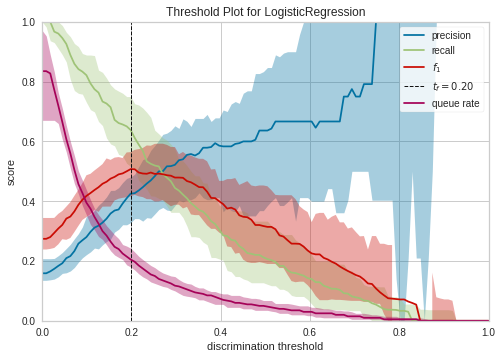

In [17]:
from sklearn.linear_model import LogisticRegression

#Baseline model        
logit = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                           verbose=0, warm_start=False)

telecom_churn_prediction(logit, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)

## <a id='4.2'>4.2. Synthetic Minority Oversampling TEchnique (SMOTE)</a>
* Randomly pick a point from the minority class.
* Compute the k-nearest neighbors (for some pre-specified k) for this point.
* Add k new points somewhere between the chosen point and each of its neighbors

Using TensorFlow backend.


Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85       547
           1       0.41      0.66      0.50       120

    accuracy                           0.77       667
   macro avg       0.66      0.72      0.68       667
weighted avg       0.82      0.77      0.79       667

Accuracy Score: 0.767616191904048
Area under curve: 0.7249619134673979 



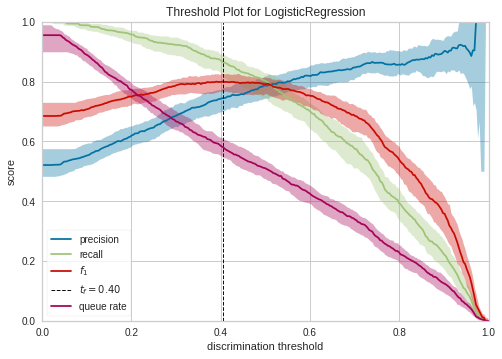

In [18]:
from imblearn.over_sampling import SMOTE

#oversampling minority class using smote
smote = SMOTE(random_state = 0)
x_smote, y_smote = smote.fit_sample(x_train, y_train)
x_smote = pd.DataFrame(data = x_smote, columns=cols)
y_smote = pd.DataFrame(data = y_smote, columns=target_col)

logit_smote = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                                 intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                                 penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                                 verbose=0, warm_start=False)

telecom_churn_prediction(logit_smote, x_smote, x_test, y_smote, y_test, "coefficients", threshold_plot=True)

## <a id='4.3'>4.3. Recursive Feature Elimination</a>
Recursive Feature Elimination (RFE) is based on the idea to repeatedly construct a model and choose either the best or worst performing feature, setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. The goal of RFE is to select features by recursively considering smaller and smaller sets of features.

Algorithm: LogisticRegression

Classification report:
               precision    recall  f1-score   support

           0       0.84      0.97      0.90       547
           1       0.50      0.13      0.21       120

    accuracy                           0.82       667
   macro avg       0.67      0.55      0.55       667
weighted avg       0.78      0.82      0.77       667

Accuracy Score: 0.8200899550224887
Area under curve: 0.552041438147471 



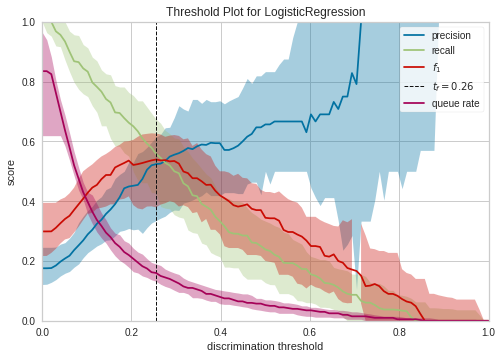

In [19]:
from sklearn.feature_selection import RFE

logit_rfe = LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                               intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
                               penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
                               verbose=0, warm_start=False)


rfe = RFE(logit_rfe, 10)
rfe = rfe.fit(x_train, y_train.values.ravel())

#identified columns Recursive Feature Elimination
idc_rfe = pd.DataFrame({"rfe_support": rfe.support_,
                        "columns": cols,
                        "ranking": rfe.ranking_,
                       })
cols_rfe = idc_rfe[idc_rfe["rfe_support"] == True]["columns"].tolist()

#applying model
telecom_churn_prediction(logit_rfe, x_train[cols_rfe], x_test[cols_rfe], y_train, y_test, "coefficients", threshold_plot=True)

table_rk = ff.create_table(idc_rfe)
py.iplot(table_rk)

## <a id='4.4'>4.4. Univariate Selection</a>
* Feature Extraction with Univariate Statistical Tests (Chi-squared for classification)
* uses the chi squared ($\chi^2$) statistical test for non-negative features to select the best features

In [20]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

#dataframe with non negative values
x_df = df_telcom_og[cols]
y_df = df_telcom_og[target_col]

#fit model with k= 3
select = SelectKBest(score_func = chi2, k = 3)
select = select.fit(x_df, y_df)

#create dataframe
score = pd.DataFrame({"features": cols, "scores": select.scores_, "p_values": select.pvalues_ })
score = score.sort_values(by = "scores", ascending=False)

#createing new label for categorical and numerical columns
score["feature_type"] = np.where(score["features"].isin(num_cols), "Numerical", "Categorical")

table_score = ff.create_table(score)
py.iplot(table_score)

#plot
trace1 = go.Scatter(x = score[score["feature_type"]=="Categorical"]["features"],
                   y = score[score["feature_type"]=="Categorical"]["scores"],
                   name = "Categorial", mode = "lines+markers",
                   marker = dict(color = "red", line = dict(width =1))
                   )

trace2 = go.Bar(x = score[score["feature_type"]=="Numerical"]["features"],
                y = score[score["feature_type"]=="Numerical"]["scores"], name = "Numerical",
                marker = dict(color = "royalblue", line = dict(width =1)),
                xaxis = "x2", yaxis = "y2"
               )
layout = go.Layout(dict(title = "Scores for Categorical & Numerical features",
                        plot_bgcolor = "rgb(243,243,243)",
                        paper_bgcolor = "rgb(243,243,243)",
                        xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     tickfont = dict(size =10),
                                     domain=[0, 0.7],
                                     tickangle = 90, zerolinewidth=1,
                                     ticklen=5, gridwidth=2),
                        yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                     title = "scores",
                                     zerolinewidth=1, ticklen=5, gridwidth=2),
                        margin = dict(b=200),
                        xaxis2=dict(domain=[0.8, 1], tickangle = 90, gridcolor = 'rgb(255, 255, 255)'),
                        yaxis2=dict(anchor='x2', gridcolor = 'rgb(255, 255, 255)')
                        )
                  )

data = [trace1, trace2]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# SUPPORT VECTOR MACHINE (SVM)

In [1]:
from sklearn.svm import SVC

#Support vector classifier using linear hyper plane
svc_lin  = SVC(C=1.0, kernel='linear', probability=True, random_state=124)

telecom_churn_prediction(svc_lin, x_train, x_test, y_train, y_test, "coefficients", threshold_plot=True)

NameError: name 'telecom_churn_prediction' is not defined

# THANK YOU